In [35]:
import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch, spectrogram, welch
import pywt

# Load the ARFF file (change the path accordingly)
file_path = 'E:\SENIOR2\Semester 2\BioMedical\project\EEG Eye State.arff'

<>:10: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Ziad\AppData\Local\Temp\ipykernel_17468\879908751.py:10: SyntaxWarning: invalid escape sequence '\S'
  file_path = 'E:\SENIOR2\Semester 2\BioMedical\project\EEG Eye State.arff'


# Importing data in pd

In [36]:
with open(file_path, 'r') as f:
    data = arff.load(f)

# Convert to DataFrame
columns = [attr[0] for attr in data['attributes']]
df = pd.DataFrame(data['data'], columns=columns)

# Display dataset info
print("Number of samples:", df.shape[0])
print("Number of features (excluding label):", df.shape[1] - 1)
print("Column names:", df.columns.tolist())

# Display label distribution (the label is likely called 'eyeDetection')
if 'eyeDetection' in df.columns:
    print("\nLabel distribution:")
    print(df['eyeDetection'].value_counts())
else:
    print("Label column not found.")

Number of samples: 14980
Number of features (excluding label): 14
Column names: ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'eyeDetection']

Label distribution:
eyeDetection
0    8257
1    6723
Name: count, dtype: int64


# s

In [37]:
eeg_data = df.iloc[:, :14].values  # EEG signals (first 14 columns)
Labels = df['eyeDetection'].astype(int).values

eeg_data_baseline = eeg_data - eeg_data.mean()


In [38]:
print(Labels.dtype)  # should print: int32 or int64
print(np.unique(Labels))  # should print: [0 1]


int64
[0 1]


In [39]:
fs = 128  # or 256, based on assumed EEG sampling rate
time_sec = np.arange(len(df)) / fs


In [40]:
eeg_data.shape[1]
num_samples = 14980
num_channels = eeg_data.shape[1]
channel_names = list(df.columns[:-1])

clipped_eeg = np.clip(eeg_data_baseline, -350, 500)  # adjust range as needed
print(num_channels)
print(channel_names)
print(Labels)

14
['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
[0 0 0 ... 1 1 1]


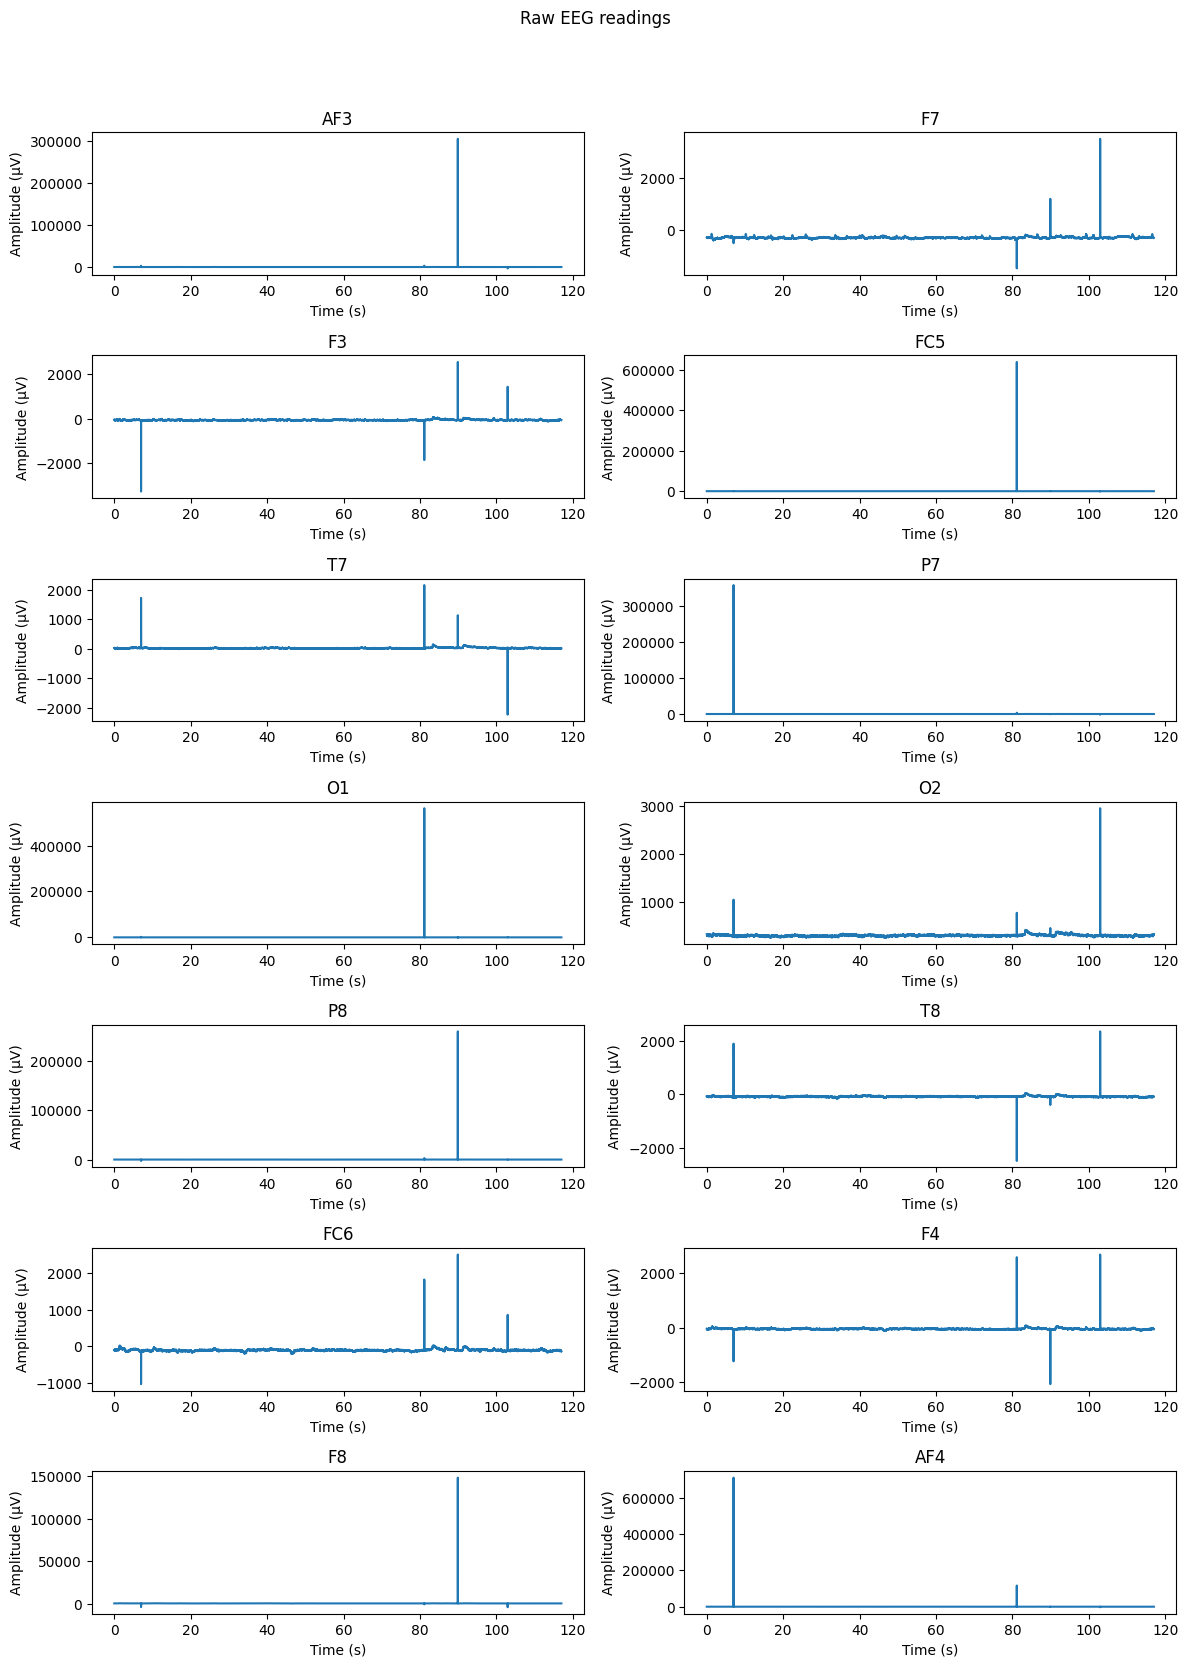

In [41]:
rows = int(np.ceil(num_channels / 2))  # 2 columns, as before
plt.figure(figsize=(12, 2.5 * rows))
plt.suptitle('Raw EEG readings')

for i in range(num_channels):
    plt.subplot(rows, 2, i + 1)
    plt.plot(time_sec, eeg_data_baseline[:, i])
    plt.title(f'{channel_names[i]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Keeps space for the super title
plt.show()


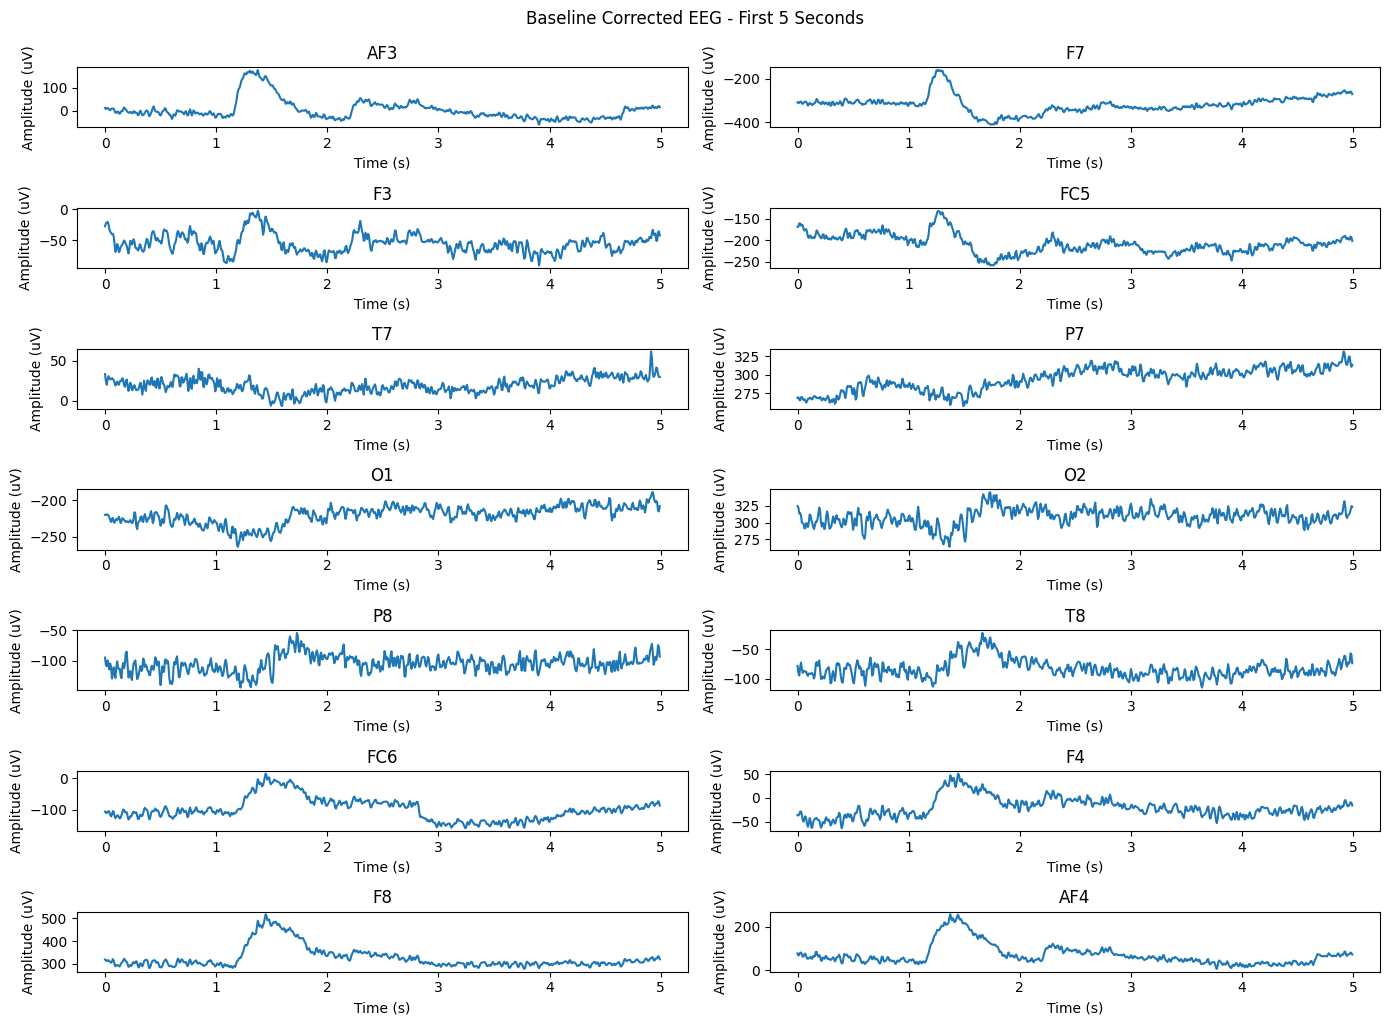

In [42]:
# Define duration and corresponding number of samples
duration_sec = 5
num_samples = duration_sec * fs

# Extract first 5 seconds
eeg_segment = eeg_data_baseline[:num_samples, :]

# Time vector
time_sec = np.arange(num_samples) / fs

# Plot
plt.figure(figsize=(14, 10))
for i in range(eeg_segment.shape[1]):
    plt.subplot((num_channels + 1) // 2, 2, i + 1)
    plt.plot(time_sec, eeg_segment[:, i])
    plt.title(channel_names[i])
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (uV)")  # or unknown unit if not confirmed
    plt.tight_layout()

plt.suptitle("Baseline Corrected EEG - First 5 Seconds", y=1.02)
plt.show()

# Filters

In [43]:
# Notch filter to remove 50 Hz
def notch_filter(signal, fs, freq=50, Q=30):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, signal)

# Bandpass filter for EMG (20-450 Hz)
def bandpass_filter(signal, fs, lowcut=0.5, highcut=45, order=4):
    b, a = butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
    return filtfilt(b, a, signal)

# Baseline correction and normalization
def preprocess_eeg_channel(signal):
    # signal = notch_filter(signal, fs) #50Hz 
    # signal = notch_filter(signal, fs, 60) #60Hz 
    signal = bandpass_filter(signal, fs)
    return signal

In [45]:
# Apply preprocessing to all data
eeg_cleaned = np.zeros_like(eeg_data_baseline)
for i in range(num_channels):
    eeg_cleaned[:, i] = preprocess_eeg_channel(eeg_data_baseline[:, i])

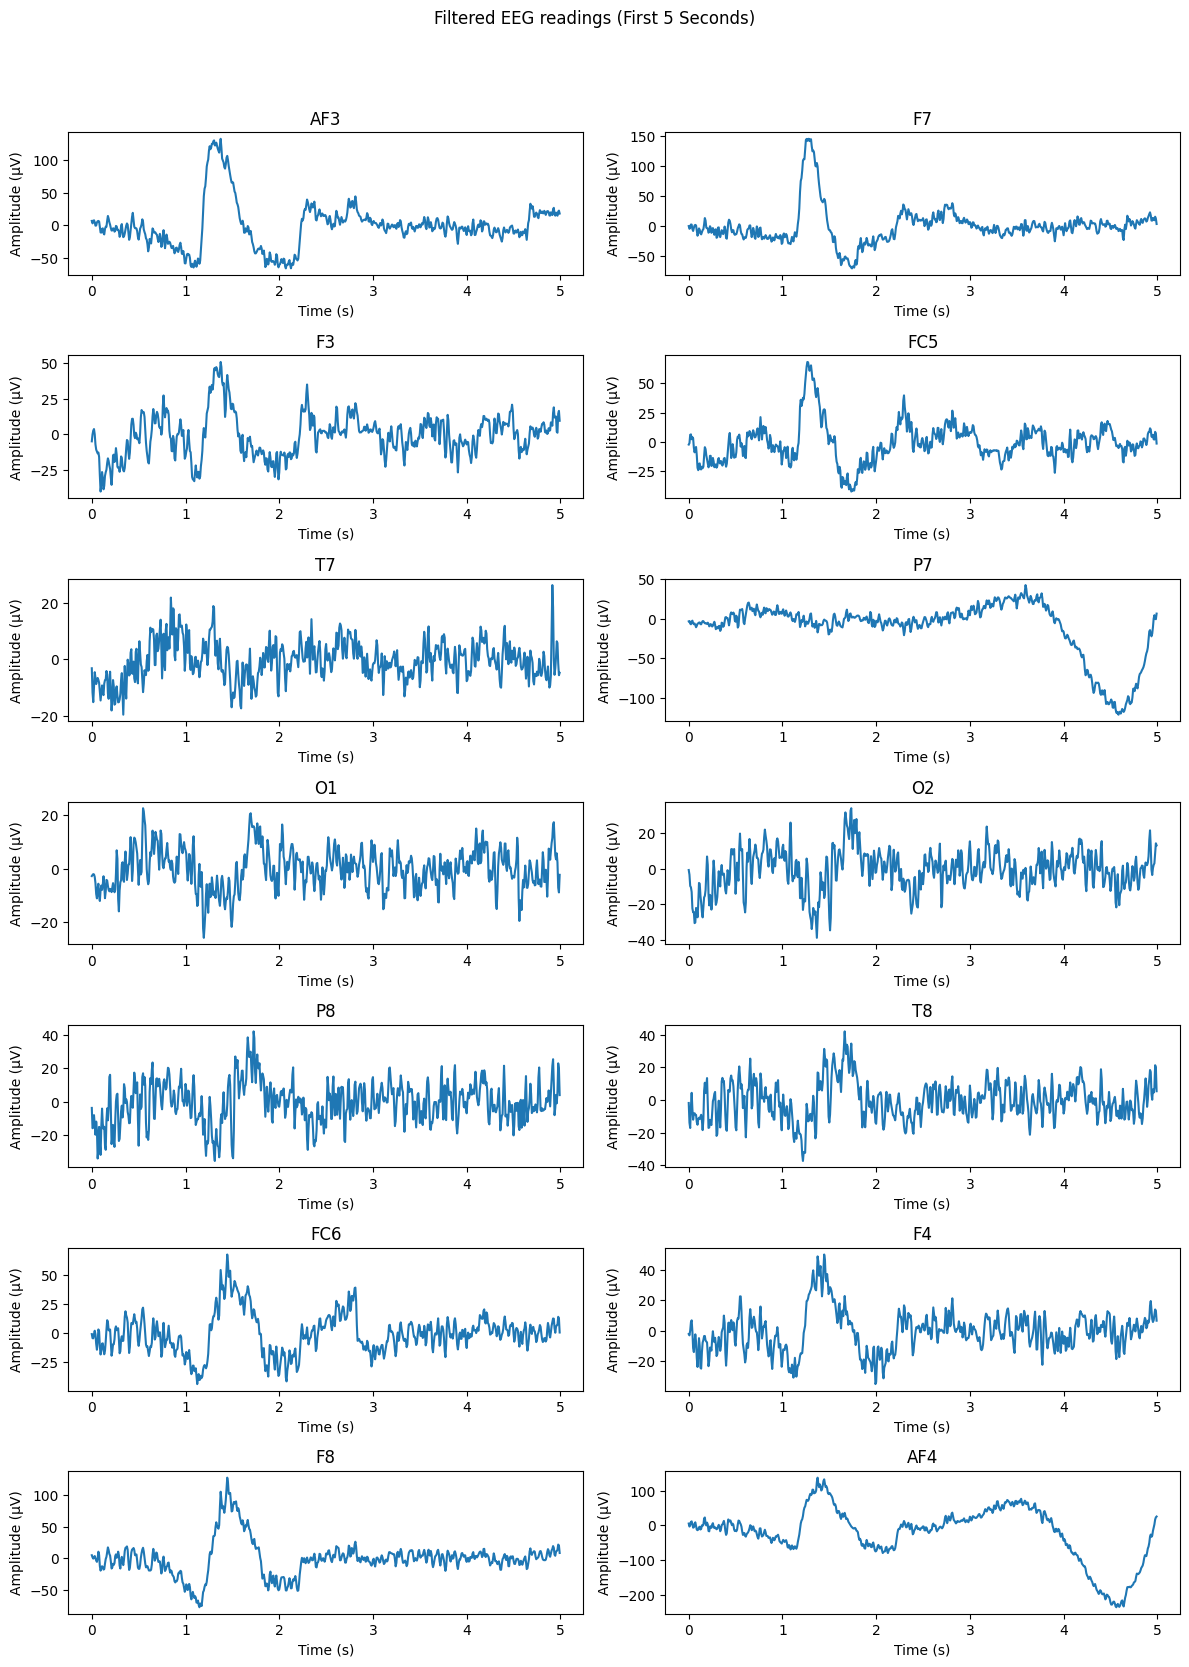

In [46]:
eeg_cleaned_segment = eeg_cleaned[:num_samples, :]

plt.figure(figsize=(12, 2.5 * rows))
plt.suptitle('Filtered EEG readings (First 5 Seconds)')

for i in range(num_channels):
    plt.subplot(rows, 2, i + 1)
    plt.plot(time_sec, eeg_cleaned_segment[:, i])
    plt.title(f'{channel_names[i]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


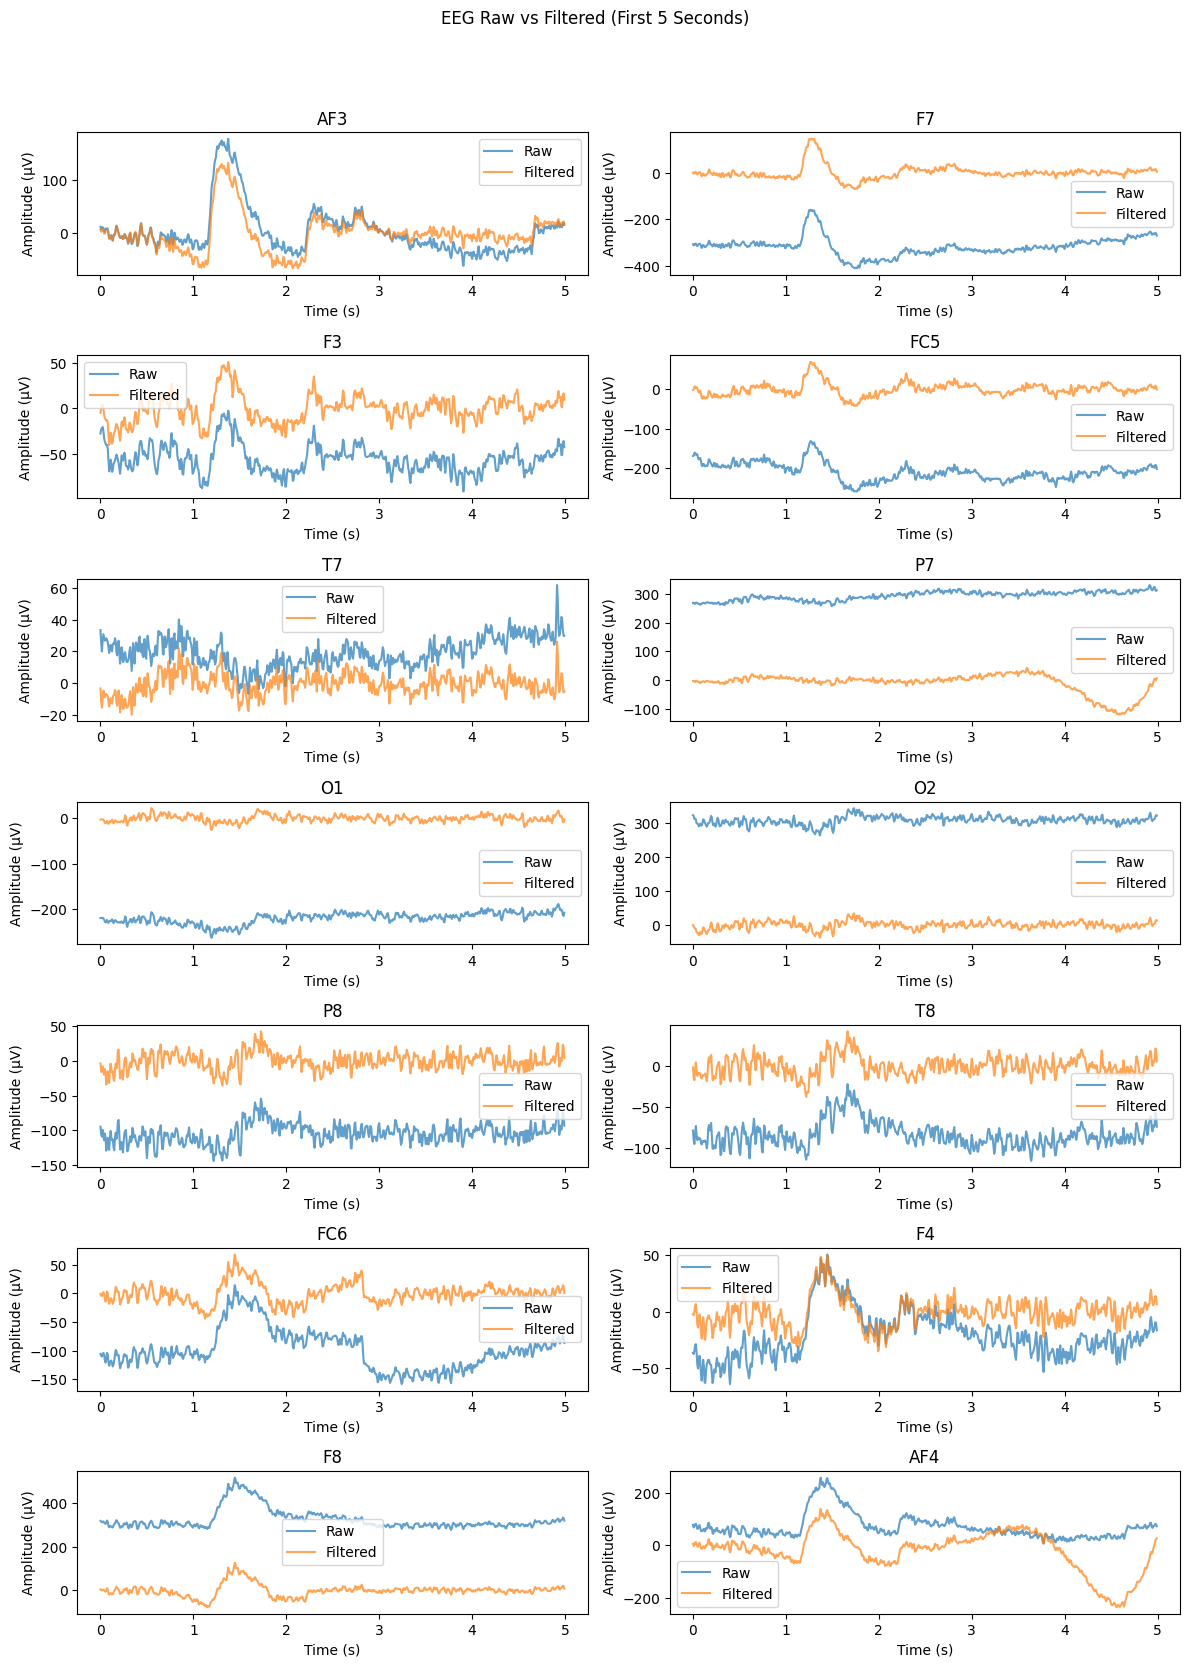

In [47]:
plt.figure(figsize=(12, 2.5 * rows))
plt.suptitle('EEG Raw vs Filtered (First 5 Seconds)')

for i in range(num_channels):
    plt.subplot(rows, 2, i + 1)
    plt.plot(time_sec, eeg_segment[:, i], label='Raw', alpha=0.7)
    plt.plot(time_sec, eeg_cleaned_segment[:, i], label='Filtered', alpha=0.7)
    plt.title(f'{channel_names[i]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Artifact Removal

In [41]:
Labels.shape
eeg_cleaned.shape

(14980, 14)

# Smoothing

In [27]:
# Smoothing using moving average
def moving_average(signal, window_size=10):
    return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

eeg_smoothed = np.zeros_like(clipped_eeg)  # shape: (num_samples, num_channels)
for i in range(num_channels):
    eeg_smoothed[:, i] = moving_average(clipped_eeg[:, i])

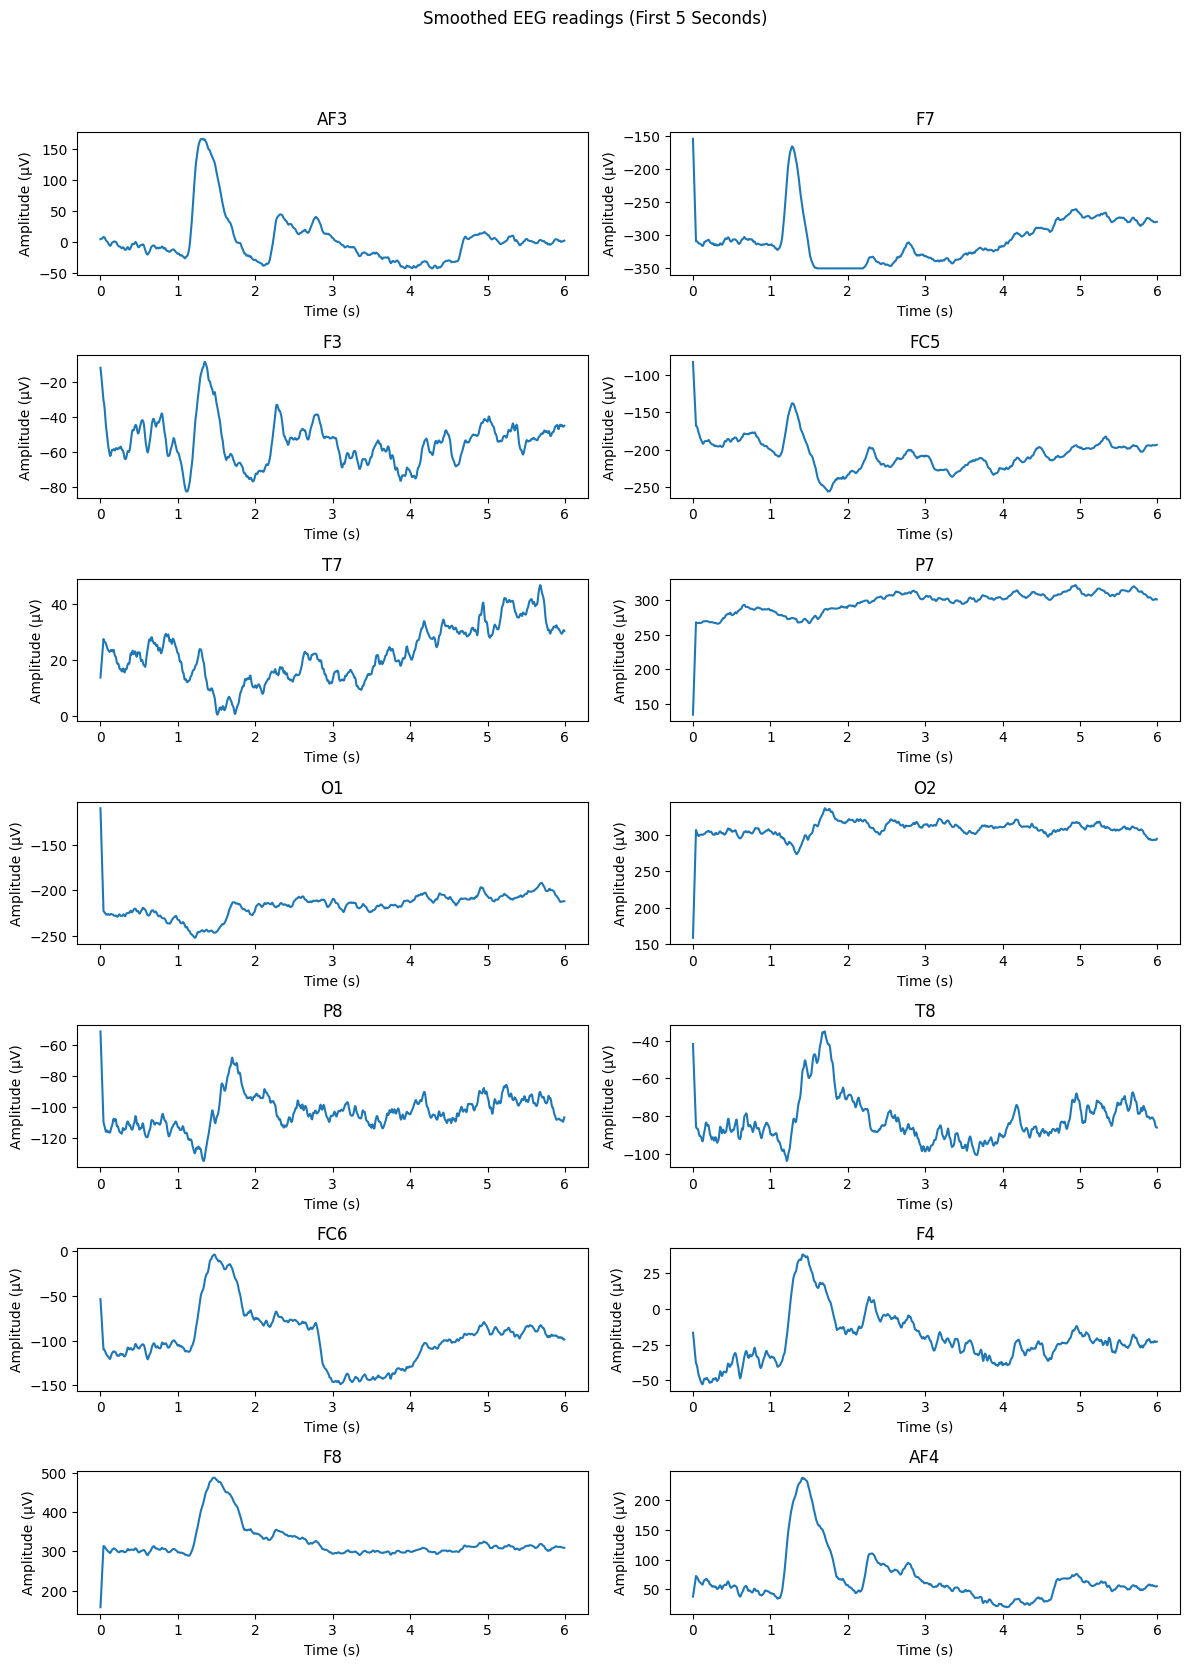

In [28]:
# Define duration and corresponding number of samples
duration_sec = 6
num_samples = duration_sec * fs

# Extract first 5 seconds
eeg_segment = eeg_data_baseline[:num_samples, :]

# Time vector
time_sec = np.arange(num_samples) / fs

eeg_smoothed_segment = eeg_smoothed[:num_samples, :]

plt.figure(figsize=(12, 2.5 * rows))
plt.suptitle('Smoothed EEG readings (First 5 Seconds)')

for i in range(num_channels):
    plt.subplot(rows, 2, i + 1)
    plt.plot(time_sec, eeg_smoothed_segment[:, i])
    plt.title(f'{channel_names[i]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


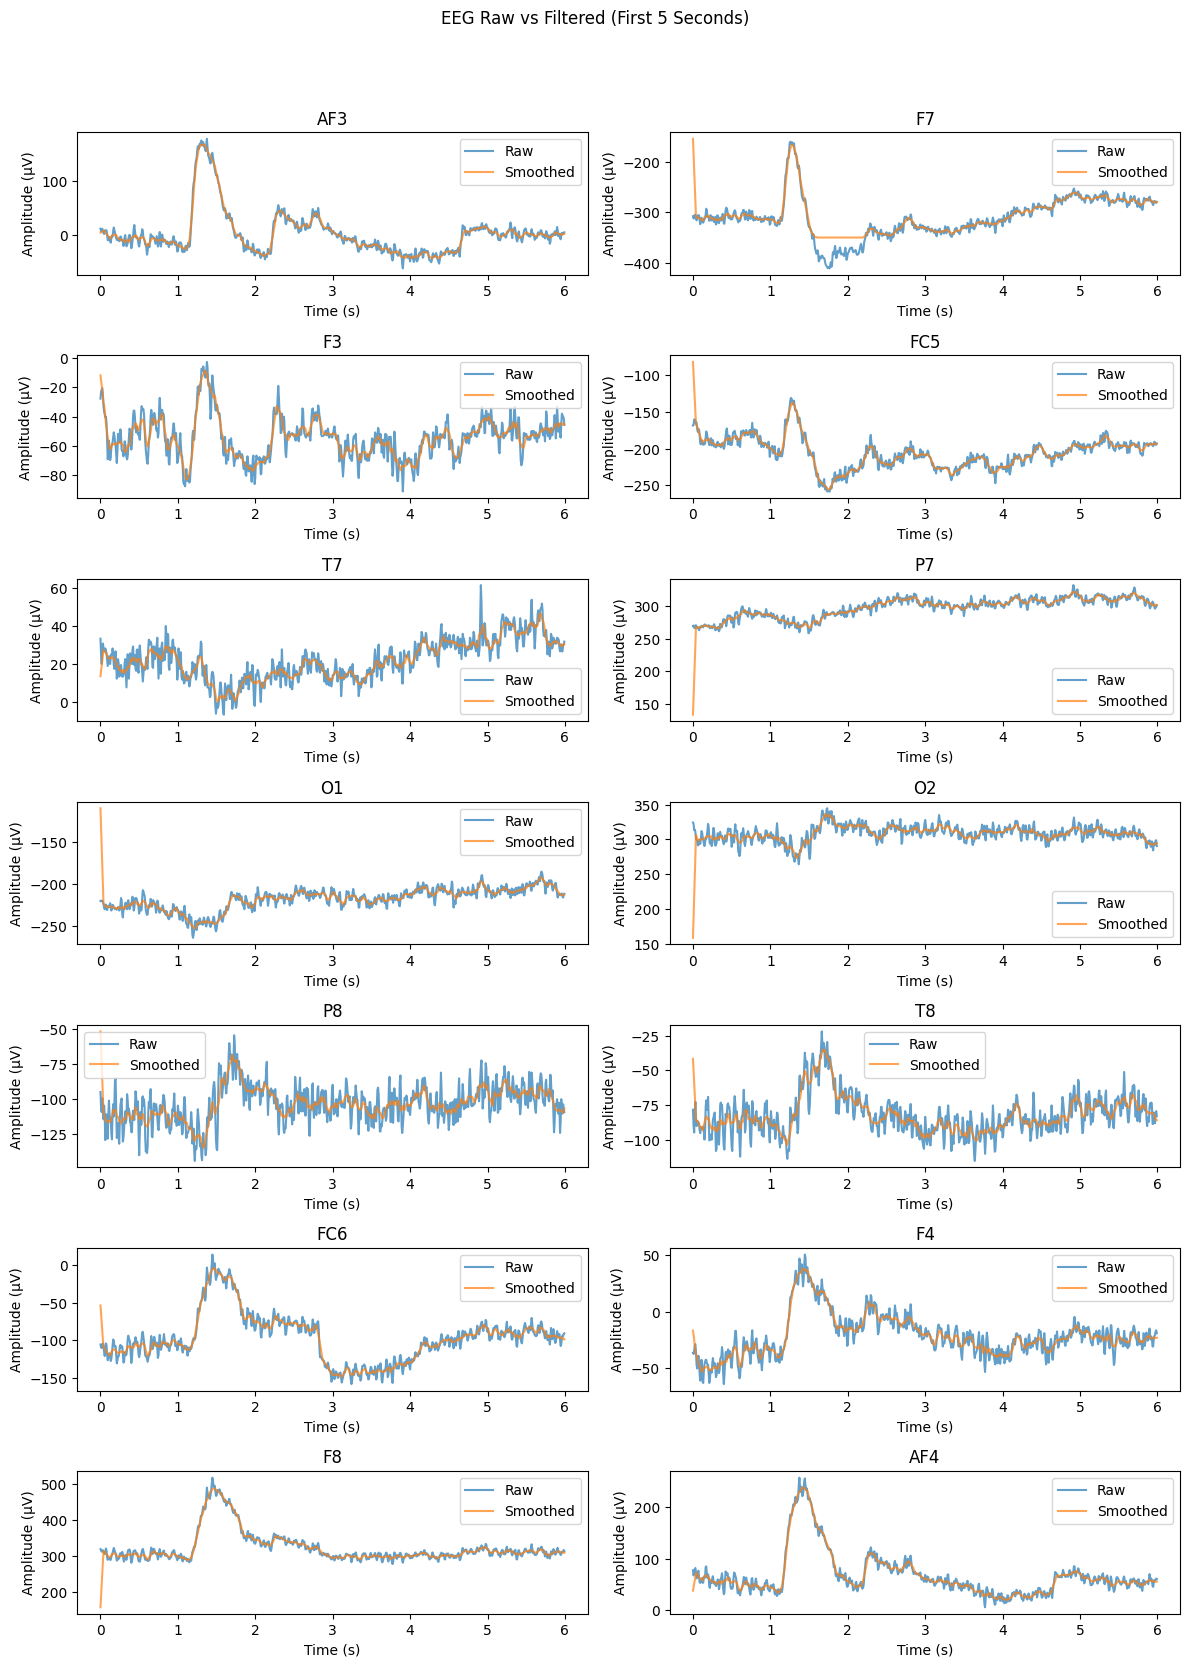

In [29]:
plt.figure(figsize=(12, 2.5 * rows))
plt.suptitle('EEG Raw vs Filtered (First 5 Seconds)')

for i in range(num_channels):
    plt.subplot(rows, 2, i + 1)
    plt.plot(time_sec, eeg_segment[:, i], label='Raw', alpha=0.7)
    plt.plot(time_sec, eeg_smoothed_segment[:, i], label='Smoothed', alpha=0.7)
    plt.title(f'{channel_names[i]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# FFT

In [48]:
#''' FFT, Power spectrum and Wavelet transform for all emg data 
# === Compute FFT for each EMG channel ===
fft_vals = []
freqs = []

for i in range(num_channels):
    signal = eeg_cleaned[:, i]
    n = len(signal)
    freqs.append(np.fft.rfftfreq(n, d=1/fs))  # Frequencies
    fft_vals.append(np.abs(np.fft.rfft(signal)))  # Magnitude of FFT

# === Compute Power Spectrum using Welch ===
Pxx_vals = []
f_vals = []

for i in range(num_channels):
    f, Pxx = welch(eeg_cleaned[:, i], fs=fs, nperseg=1024)
    f_vals.append(f)
    Pxx_vals.append(Pxx)

# === Compute Continuous Wavelet Transform (CWT) ===
scales = np.arange(1, 128)
cwt_vals = []

for i in range(num_channels):
    signal = eeg_cleaned[:, i]
    coef, freqs_cwt = pywt.cwt(signal, scales, 'morl', sampling_period=1/fs)
    cwt_vals.append((coef, freqs_cwt))




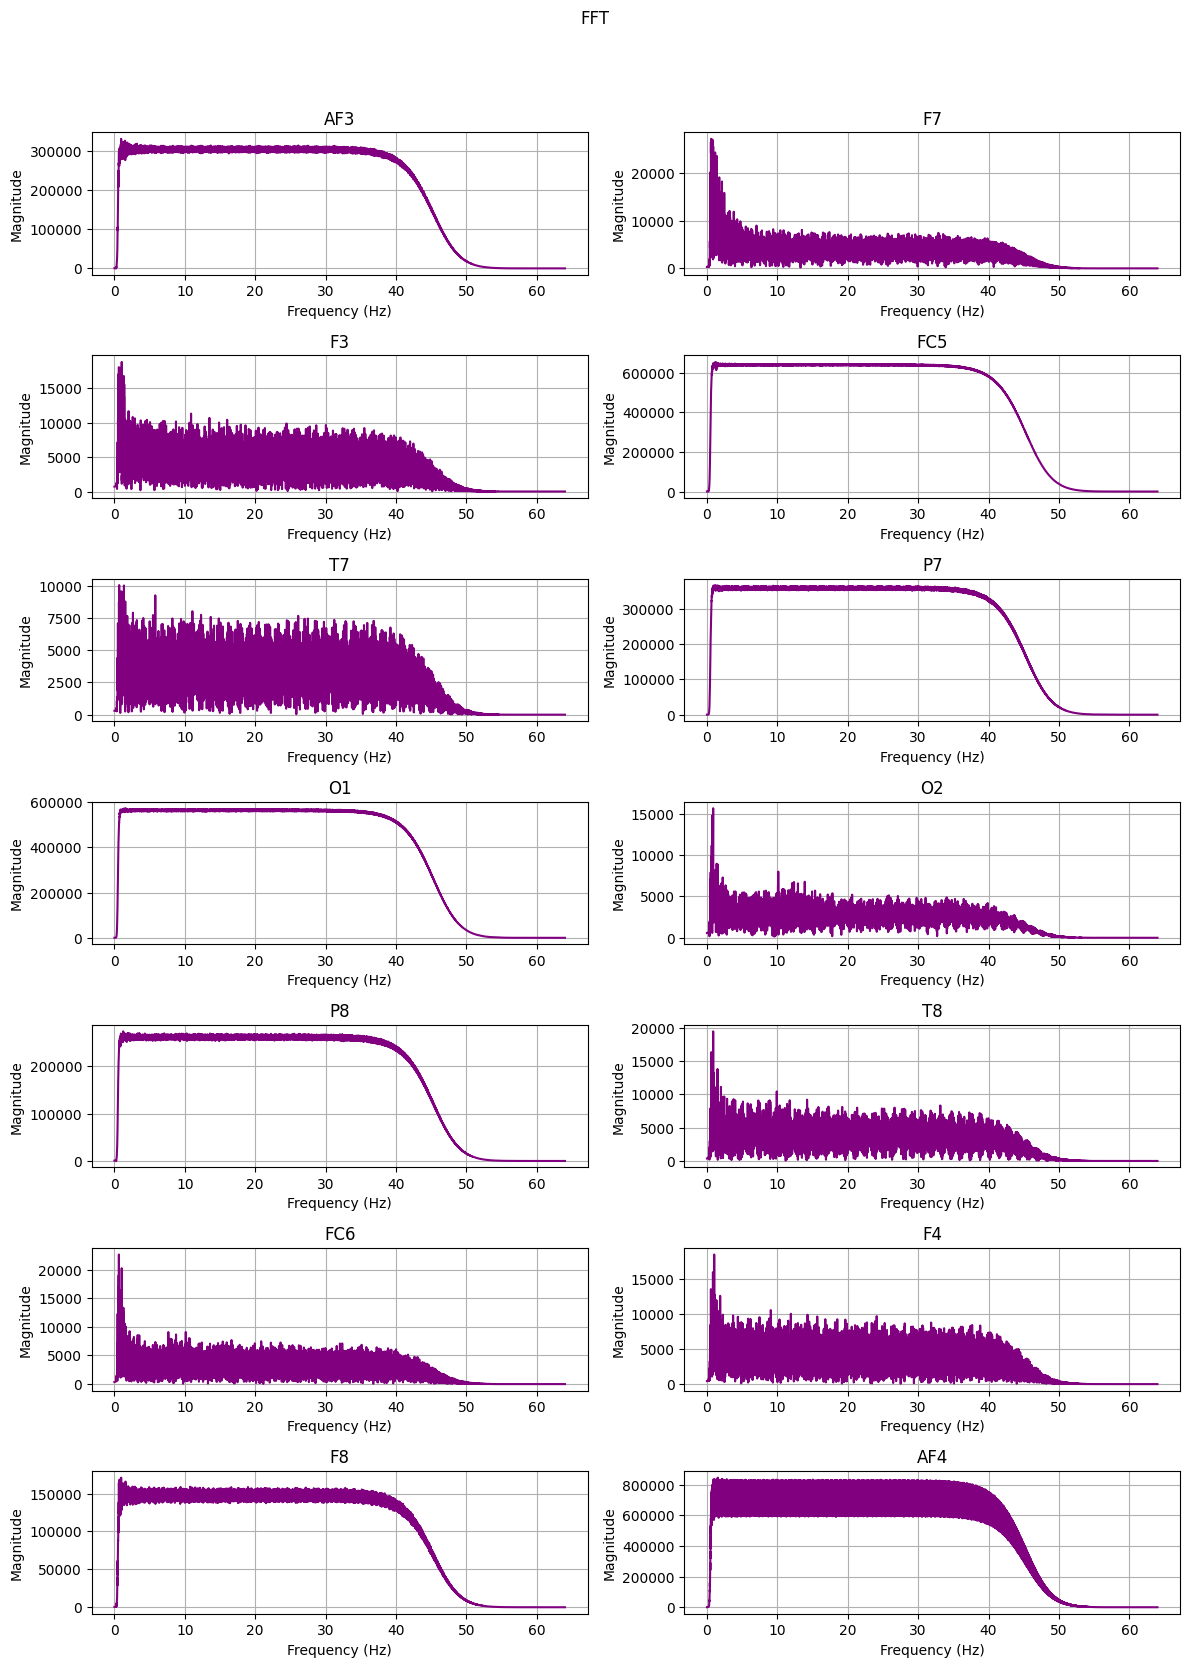

In [49]:
# === Plot FFT ===
plt.figure(figsize=(12, 2.5 * rows))
plt.suptitle('FFT')
for i in range(num_channels):
    plt.subplot(rows, 2, i + 1)
    plt.plot(freqs[i], fft_vals[i], color='purple')
    plt.title(f'{channel_names[i]}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



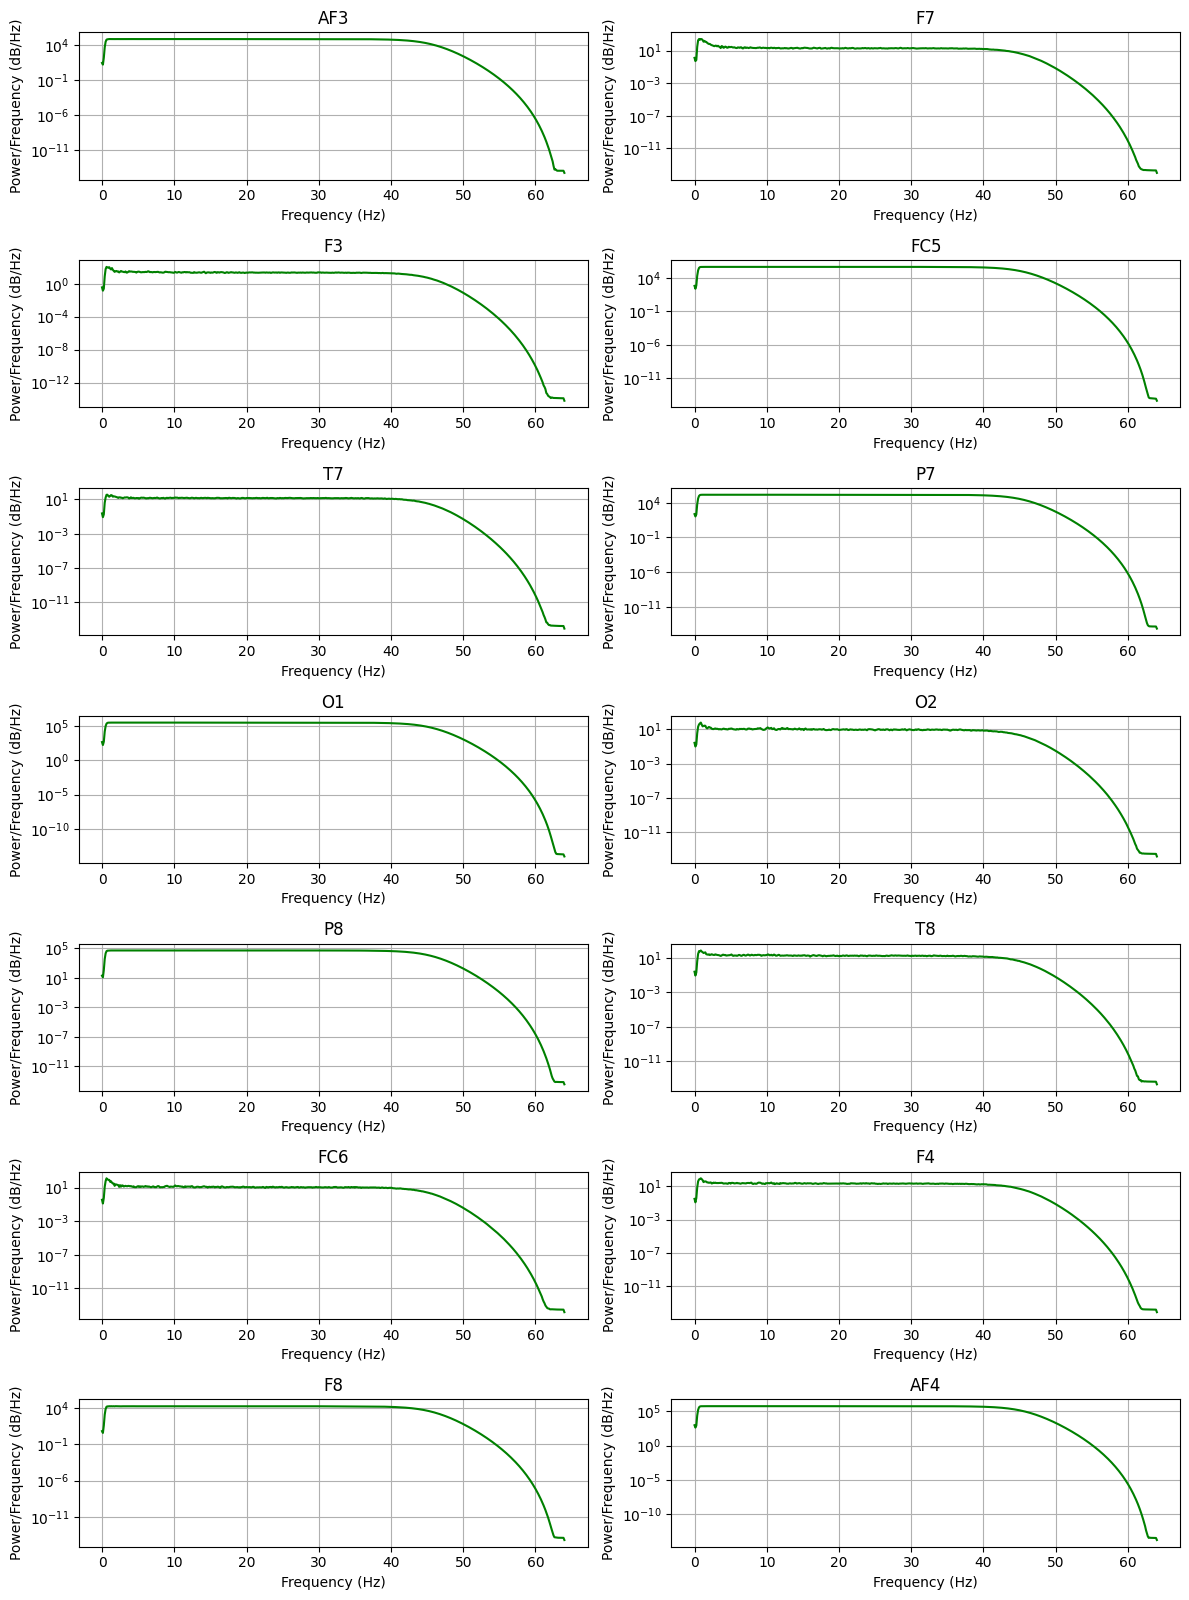

In [50]:
# === Plot Power Spectrum ===
plt.figure(figsize=(12, 2.5 * rows))
for i in range(num_channels):
    plt.subplot(rows, 2, i + 1)
    plt.semilogy(f_vals[i], Pxx_vals[i], color='green')
    plt.title(f'{channel_names[i]}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.grid()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Data Segmentation

In [51]:
import numpy as np
from scipy.stats import mode

def segment_eeg_and_labels(eeg_data, labels, fs, trial_duration_sec):
    """
    eeg_data: np.array of shape (n_samples, n_channels)
    labels: np.array of shape (n_samples,)
    fs: sampling frequency (Hz)
    trial_duration_sec: trial length in seconds (e.g., 1s)
    
    Returns:
        segmented_eeg: np.array of shape (n_trials, n_channels, n_samples_per_trial)
        segmented_labels: np.array of shape (n_trials,)
    """
    samples_per_trial = fs * trial_duration_sec
    total_samples = eeg_data.shape[0]
    n_channels = eeg_data.shape[1]
    
    n_trials = total_samples // samples_per_trial  # truncate excess
    
    # Truncate data and labels
    truncated_eeg = eeg_data[:n_trials * samples_per_trial]
    truncated_labels = labels[:n_trials * samples_per_trial]
    
    # Reshape
    segmented_eeg = truncated_eeg.reshape(n_trials, samples_per_trial, n_channels).transpose(0, 2, 1)  # → (n_trials, n_channels, n_samples)
    segmented_labels = truncated_labels.reshape(n_trials, samples_per_trial)
    majority_labels = mode(segmented_labels, axis=1).mode.squeeze()  # → (n_trials,)

    return segmented_eeg, majority_labels


In [52]:
fs = 128  # Hz
trial_duration = 1  # second

segmented_eeg, segmented_labels = segment_eeg_and_labels(eeg_cleaned, Labels, fs, trial_duration)

print("Segmented EEG shape:", segmented_eeg.shape)      # (n_trials, 14, 128)
print("Segmented labels shape:", segmented_labels.shape)  # (n_trials,)

Segmented EEG shape: (117, 14, 128)
Segmented labels shape: (117,)


# Feature calculation

In [63]:
import numpy as np
from scipy.signal import welch

# EEG frequency bands
eeg_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

def extract_features_per_trial(trial, fs):
    """
    Extract features from a single trial: shape (14, 128)
    Returns a feature vector of shape (98,)
    """
    features = []

    for channel_data in trial:  # iterate over 14 channels
        # --- Time-domain features ---
        rms = np.sqrt(np.mean(channel_data ** 2))
        mav = np.mean(np.abs(channel_data))
        features.extend([rms, mav])

        # --- Frequency-domain features ---
        freqs, psd = welch(channel_data, fs=fs, nperseg=fs)  # 1-second window
        total_power = np.sum(psd)

        for band_range in eeg_bands.values():
            band_power = np.sum(psd[(freqs >= band_range[0]) & (freqs <= band_range[1])])
            rel_power = band_power / total_power if total_power > 0 else 0
            features.append(rel_power)

    return np.array(features)


In [64]:
def extract_features_batch(eeg_trials, fs):
    return np.array([extract_features_per_trial(trial, fs) for trial in eeg_trials])


In [65]:
fs = 128
EEG_features = extract_features_batch(segmented_eeg, fs)
print("Extracted EEG feature shape:", EEG_features.shape)  # Expect (n_trials, 98)


Extracted EEG feature shape: (117, 98)


# For visualization only

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.fft import fft, fftfreq
import pywt

# EEG frequency bands
eeg_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

def extract_visual_features(trial, fs):
    """
    Extract extended features from a single EEG trial for visualization.
    trial: shape (14, 128)
    Returns: dict of features per channel
    """
    visual_features = {}
    
    for i, channel_data in enumerate(trial):
        feats = {}

        # --- Time-domain features ---
        feats['RMS'] = np.sqrt(np.mean(channel_data ** 2))
        feats['MAV'] = np.mean(np.abs(channel_data))
        feats['WAV'] = np.sum(np.abs(np.diff(channel_data)))
        feats['VAR'] = np.var(channel_data)

        # --- Frequency-domain: PSD ---
        freqs, psd = welch(channel_data, fs=fs, nperseg=fs)
        total_power = np.sum(psd)

        for band_name, (low, high) in eeg_bands.items():
            band_power = np.sum(psd[(freqs >= low) & (freqs <= high)])
            feats[f'{band_name}_rel_power'] = band_power / total_power if total_power > 0 else 0

        # --- Mean & Median Frequency ---
        feats['mean_freq'] = np.sum(freqs * psd) / np.sum(psd) if np.sum(psd) > 0 else 0
        cumulative_power = np.cumsum(psd)
        feats['median_freq'] = freqs[np.searchsorted(cumulative_power, cumulative_power[-1] / 2)]

        # --- FFT-based Features ---
        fft_vals = np.abs(fft(channel_data))[:len(channel_data)//2]
        feats['fft_mean'] = np.mean(fft_vals)
        feats['fft_max'] = np.max(fft_vals)
        feats['fft_std'] = np.std(fft_vals)

        # --- Wavelet Energy (db4, 4 levels) ---
        coeffs = pywt.wavedec(channel_data, 'db4', level=4)
        energy = np.array([np.sum(c**2) for c in coeffs])
        total_energy = np.sum(energy)
        for j, e in enumerate(energy):
            feats[f'wavelet_L{j}_rel_energy'] = e / total_energy if total_energy > 0 else 0

        visual_features[f'channel_{i+1}'] = feats

    return visual_features


def plot_visual_features(features_dict):
    """
    Plot averaged features for each channel in a 4-row layout.
    features_dict: output from extract_visual_features_all_trials
    """
    channels = list(features_dict.keys())
    n_channels = len(channels)
    feature_names = list(features_dict[channels[0]].keys())
    n_features = len(feature_names)

    fig, axs = plt.subplots(nrows=4, ncols=int(np.ceil(n_features / 4)), figsize=(20, 12))
    axs = axs.flatten()

    for idx, feat_name in enumerate(feature_names):
        values = [features_dict[ch][feat_name] for ch in channels]
        axs[idx].bar(channels, values)
        axs[idx].set_title(feat_name)
        axs[idx].tick_params(axis='x', rotation=45)

    # Hide unused subplots
    for j in range(len(feature_names), len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle('Average EEG Features per Channel', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()





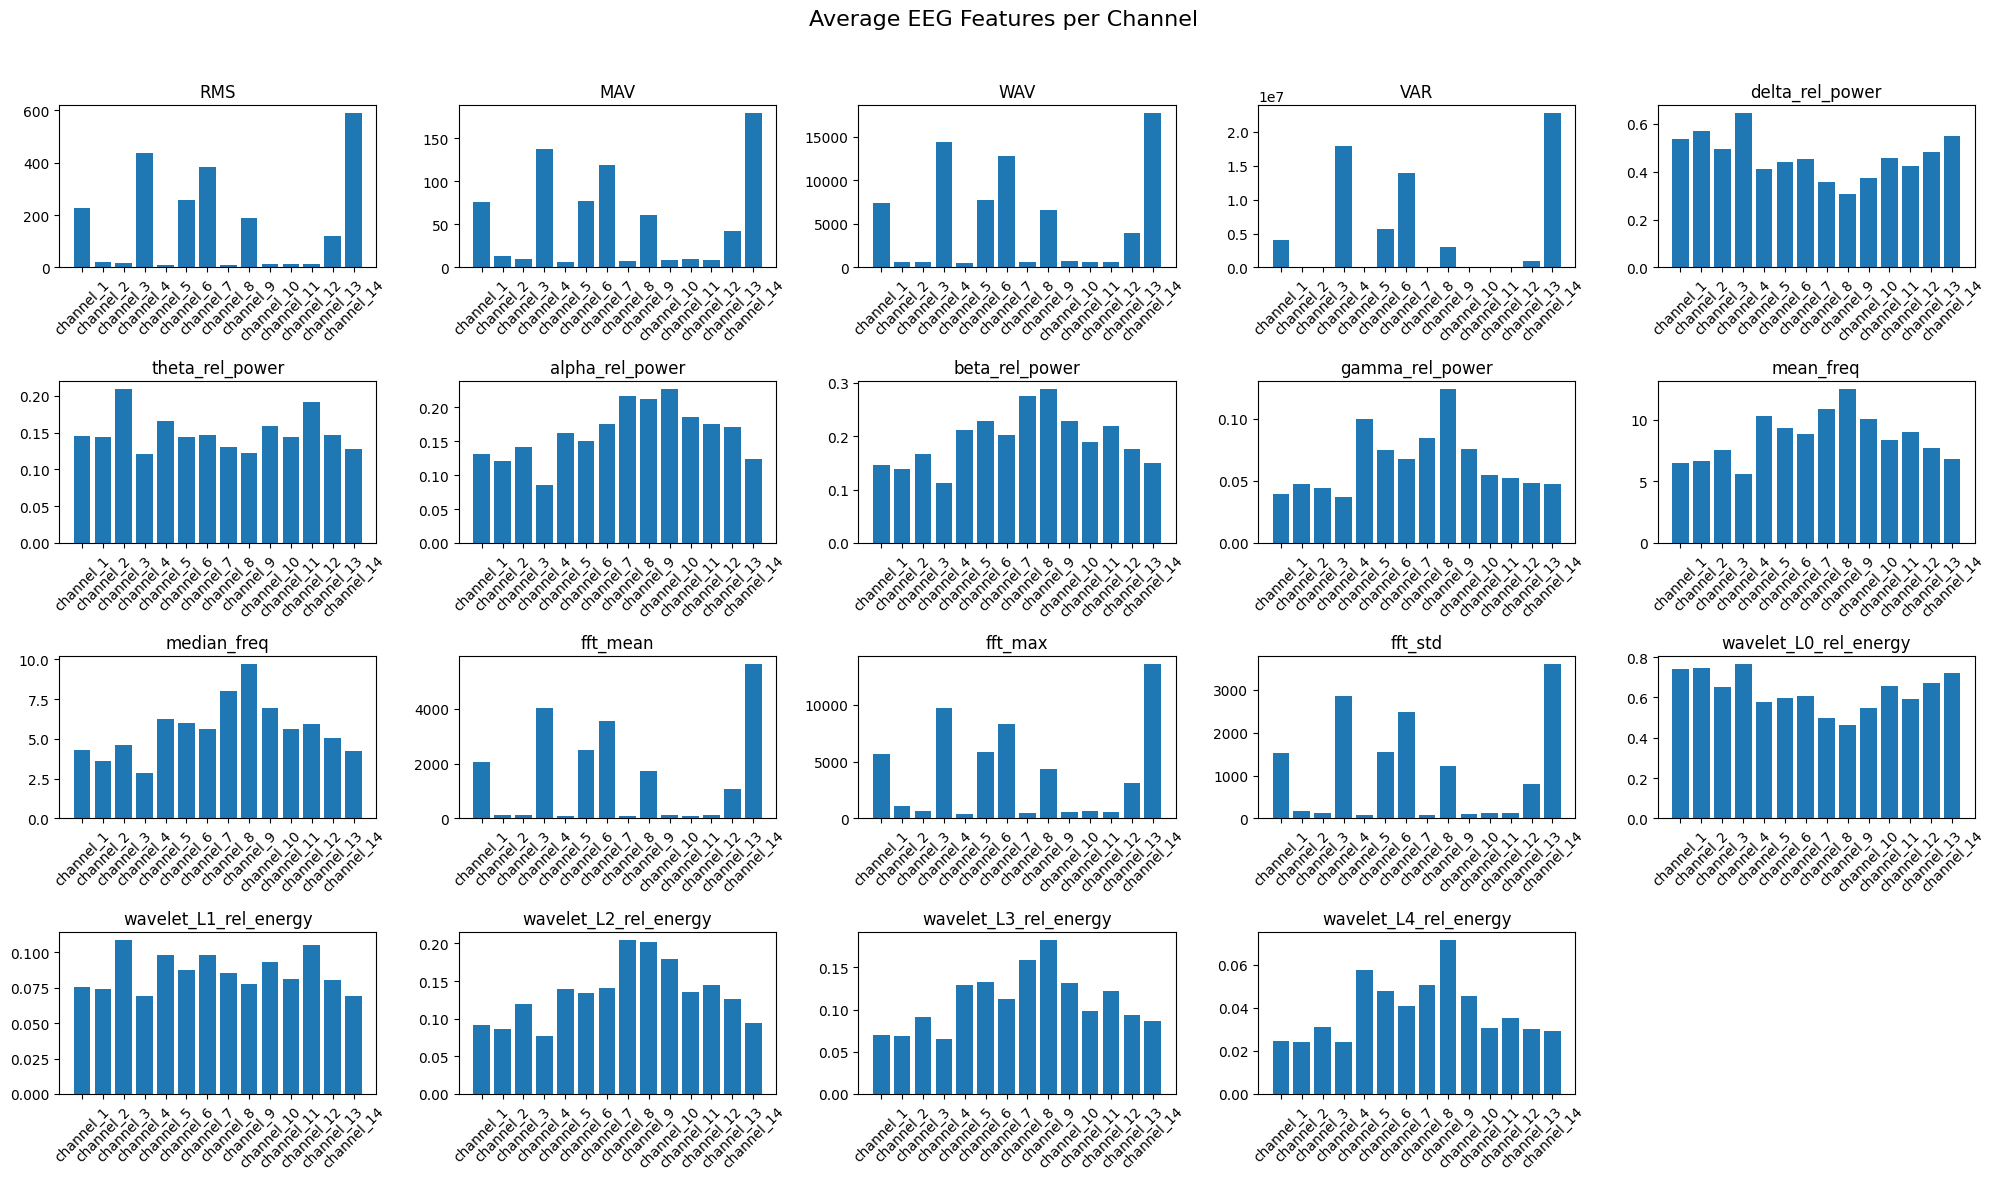

In [84]:
def extract_visual_features_all_trials(eeg_trials, fs):
    """
    Extract extended features for all EEG trials.
    Returns a dictionary: {channel_1: {feature1: avg, ...}, ...}
    """
    n_channels = eeg_trials.shape[1]
    all_features = {f'channel_{ch+1}': {} for ch in range(n_channels)}

    # Temporary container: {channel: {feature: [values over trials]}}
    temp_storage = {f'channel_{ch+1}': {} for ch in range(n_channels)}

    for trial in eeg_trials:
        trial_feats = extract_visual_features(trial, fs)
        for ch in trial_feats:
            for feat_name, value in trial_feats[ch].items():
                temp_storage[ch].setdefault(feat_name, []).append(value)

    # Average features across trials
    for ch in temp_storage:
        for feat_name, values in temp_storage[ch].items():
            all_features[ch][feat_name] = np.mean(values)

    return all_features

averaged_features = extract_visual_features_all_trials(segmented_eeg, fs)
plot_visual_features(averaged_features)

# Data Splitting

In [61]:
from sklearn.model_selection import train_test_split

# Split into training (80%) and testing (20%)
TrainingFeatures, TestingData, TrainingLabels, TestingLabels = train_test_split(
    EEG_features, 
    segmented_labels, 
    test_size=0.2, 
    random_state=42,  # For reproducibility
    stratify=segmented_labels    # Preserve class distribution
)

print("Training features shape:", TrainingFeatures.shape)
print("Training labels shape:", TrainingLabels.shape)
print("Testing features shape:", TestingData.shape)
print("Testing labels shape:", TestingLabels.shape)

Training features shape: (93, 266)
Training labels shape: (93,)
Testing features shape: (24, 266)
Testing labels shape: (24,)


# Training

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train
clf.fit(TrainingFeatures, TrainingLabels)

# Evaluate
PredictedLabels = clf.predict(TestingData)
print("Confusion Matrix:\n", confusion_matrix(TestingLabels, PredictedLabels))
print("\nClassification Report:\n", classification_report(TestingLabels, PredictedLabels))

Confusion Matrix:
 [[ 9  4]
 [10  1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.69      0.56        13
           1       0.20      0.09      0.12        11

    accuracy                           0.42        24
   macro avg       0.34      0.39      0.34        24
weighted avg       0.35      0.42      0.36        24

